In [53]:
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from yellowbrick.classifier import ClassificationReport, ConfusionMatrix


import pandas as pd

from matplotlib import pyplot

## TODO:

- check for information leakage/over fitting etc
- hyperparameter tuning
- more features
- feature importances
- combine prime/opt team results  for round predictor

In [80]:
df = pd.read_parquet('../data/raw/features.parquet', use_pandas_metadata=True)
df.columns

Index(['season', 'round', 'venue', 'date', 'prime_team', 'prime_team_points',
       'opt_team', 'opt_team_points', 'home_away', 'prime_margin', 'result',
       'prime_margin_1', 'prime_margin_2', 'prime_margin_3', 'prime_margin_4',
       'prime_margin_5', 'prime_margin_6', 'pm_l6w'],
      dtype='object')

In [81]:
df.head()

,season,round,venue,date,prime_team,prime_team_points,opt_team,opt_team_points,home_away,prime_margin,result,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w
0,2018,1,"Optus Stadium, Perth",2018-03-10,Rabbitohs,20.0,Warriors,32.0,home,-12.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,2,"Panthers Stadium, Penrith",2018-03-17,Rabbitohs,14.0,Panthers,18.0,away,-4.0,-1.0,-12.0,NaN,NaN,NaN,NaN,NaN,-12.0
2,2018,3,"Stadium Australia, Sydney",2018-03-24,Rabbitohs,34.0,Sea Eagles,6.0,home,28.0,1.0,-4.0,-12.0,NaN,NaN,NaN,NaN,-8.0
3,2018,4,"Stadium Australia, Sydney",2018-03-30,Rabbitohs,20.0,Bulldogs,16.0,home,4.0,1.0,28.0,-4.0,-12.0,NaN,NaN,NaN,4.0
4,2018,5,"Netstrata Jubilee Stadium, Sydney",2018-04-06,Rabbitohs,12.0,Dragons,16.0,away,-4.0,-1.0,4.0,28.0,-4.0,-12.0,NaN,NaN,4.0


In [82]:
df.dtypes

season                  int64
round                   int64
venue                category
date                   object
prime_team           category
prime_team_points     float64
opt_team             category
opt_team_points       float64
home_away            category
prime_margin          float64
result                float64
prime_margin_1        float64
prime_margin_2        float64
prime_margin_3        float64
prime_margin_4        float64
prime_margin_5        float64
prime_margin_6        float64
pm_l6w                float64
dtype: object

In [83]:
y_cols = 'result'
X_cols = ['prime_team', 'home_away', 'opt_team', 'venue', 'prime_margin_1', 'prime_margin_2', 'prime_margin_3', 
          'prime_margin_4', 'prime_margin_5', 'prime_margin_6', 'pm_l6w']

In [84]:
history_df=df.loc[(df.result!=0) & ~df.result.isna(), :] # drop out the two draws, we're not trying to predict those so lets keep this binary
categories = {-1: 0, 1:1}

In [85]:
history_df

,season,round,venue,date,prime_team,prime_team_points,opt_team,opt_team_points,home_away,prime_margin,result,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w
0,2018,1,"Optus Stadium, Perth",2018-03-10,Rabbitohs,20.0,Warriors,32.0,home,-12.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,2,"Panthers Stadium, Penrith",2018-03-17,Rabbitohs,14.0,Panthers,18.0,away,-4.0,-1.0,-12.0,NaN,NaN,NaN,NaN,NaN,-12.000000
2,2018,3,"Stadium Australia, Sydney",2018-03-24,Rabbitohs,34.0,Sea Eagles,6.0,home,28.0,1.0,-4.0,-12.0,NaN,NaN,NaN,NaN,-8.000000
3,2018,4,"Stadium Australia, Sydney",2018-03-30,Rabbitohs,20.0,Bulldogs,16.0,home,4.0,1.0,28.0,-4.0,-12.0,NaN,NaN,NaN,4.000000
4,2018,5,"Netstrata Jubilee Stadium, Sydney",2018-04-06,Rabbitohs,12.0,Dragons,16.0,away,-4.0,-1.0,4.0,28.0,-4.0,-12.0,NaN,NaN,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,2022,25,"Queensland Country Bank Stadium, Townsville",2022-09-03,Panthers,8.0,Cowboys,38.0,away,-30.0,-1.0,34.0,4.0,-16.0,20.0,-24.0,10.0,4.666667
2216,2023,1,"BlueBet Stadium, Penrith",2023-03-03,Panthers,12.0,Broncos,13.0,home,-1.0,-1.0,-30.0,34.0,4.0,-16.0,20.0,-24.0,-2.000000
2217,2023,2,"BlueBet Stadium, Penrith",2023-03-09,Panthers,16.0,Rabbitohs,10.0,home,6.0,1.0,-1.0,-30.0,34.0,4.0,-16.0,20.0,1.833333
2240,2023,1,"Suncorp Stadium, Brisbane",2023-03-05,Dolphins,28.0,Roosters,18.0,home,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
X_df = history_df.loc[:, X_cols]
y_df = history_df.loc[:, y_cols]
y_df = y_df.replace(categories)

In [87]:
seed = 10
test_size = 0.33

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_size, random_state=seed)
#eval_set = [(X_test, y_test)]
eval_set = [(X_train, y_train), (X_test,y_test)]

[0]	validation_0-error:0.24485	validation_1-error:0.36334
[1]	validation_0-error:0.23851	validation_1-error:0.37621
[2]	validation_0-error:0.23138	validation_1-error:0.36977
[3]	validation_0-error:0.22504	validation_1-error:0.36013
[4]	validation_0-error:0.22108	validation_1-error:0.35852
[5]	validation_0-error:0.21632	validation_1-error:0.36495
[6]	validation_0-error:0.22266	validation_1-error:0.36656
[7]	validation_0-error:0.21949	validation_1-error:0.36334
[8]	validation_0-error:0.22029	validation_1-error:0.36334
[9]	validation_0-error:0.22266	validation_1-error:0.35370
[10]	validation_0-error:0.22662	validation_1-error:0.35691
[11]	validation_0-error:0.22187	validation_1-error:0.36174
[12]	validation_0-error:0.22187	validation_1-error:0.36495
[13]	validation_0-error:0.21870	validation_1-error:0.36174
[14]	validation_0-error:0.22187	validation_1-error:0.36334
[15]	validation_0-error:0.21712	validation_1-error:0.35852
[16]	validation_0-error:0.21791	validation_1-error:0.36334
[17]	va

/home/chris/miniconda3/envs/datasci/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


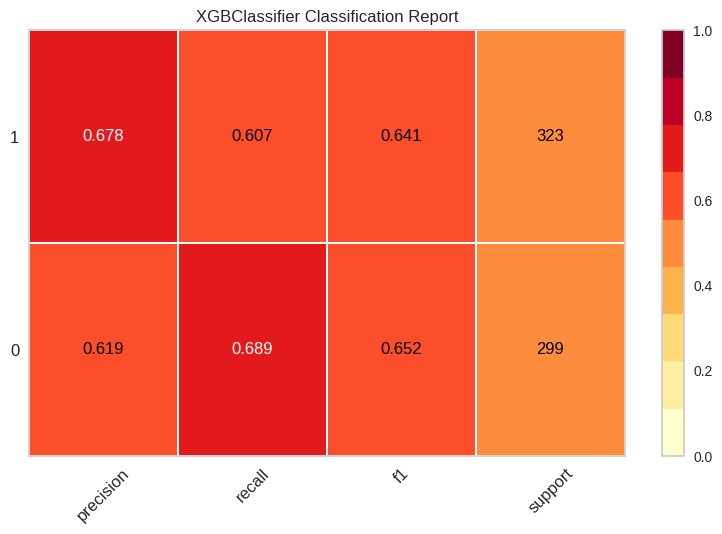

<AxesSubplot: title={'center': 'XGBClassifier Classification Report'}>

In [88]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
clf = XGBClassifier(tree_method="gpu_hist", 
                    #booster='dart',
                    enable_categorical=True, 
                    eval_metric="error",
                    early_stopping_rounds=15, 
                    n_estimators=30, 
                    learning_rate=0.1, 
                    gamma=6,
                    eta=0.01,
                    max_depth=8,
                    verbosity=1, 
                    subsample=0.9,
                    #colsample_bytree=0.9,
                    #colsample_bynode=0.9
                   )


# X is the dataframe we created in previous snippet
clf.fit(X_train, y_train,  
        eval_set=eval_set, 
        verbose=True, )


#clf = GaussianNB()
cr = ClassificationReport(clf, classes=[0,1], support=True, is_fitted=True)
cr.score(X_test, y_test)        # Evaluate the model on the test data
cr.show()                       # Finalize and show the figure

/home/chris/miniconda3/envs/datasci/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


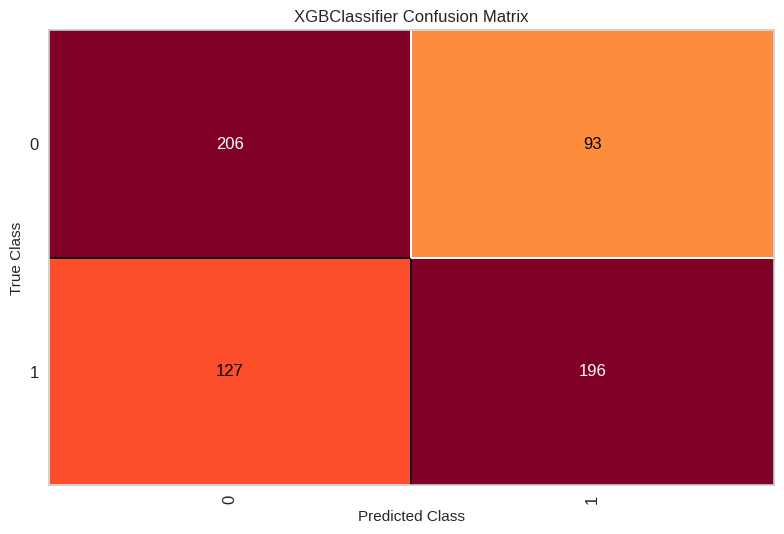

<AxesSubplot: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [89]:
cm = ConfusionMatrix(clf, classes=[0,1], is_fitted=True)
# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()


In [90]:
predictions = clf.predict(X_test)

In [91]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.63%


In [92]:
f1 = f1_score(y_test, predictions)
print("F1: %.2f%%" % (f1 * 100.0))

F1: 64.05%


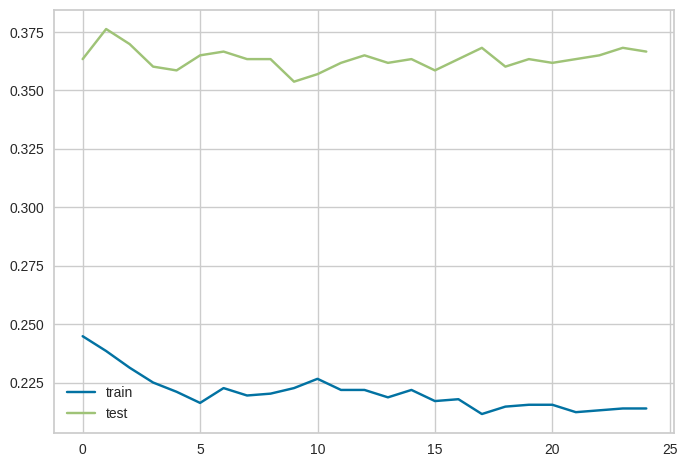

In [93]:
results = clf.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['error'], label='train')
pyplot.plot(results['validation_1']['error'], label='test')
# show the legend
pyplot.legend()
#pyplot.ylim(0,0.4)
# show the plot
pyplot.show()

In [94]:
nr_pred=clf.predict(df.loc[(df.season==2023) & 
                   (df['round']==2), X_cols])
nr_pred_proba=clf.predict_proba(df.loc[(df.season==2023) & 
                                       (df['round']==1), X_cols])

In [98]:
next_round = df.loc[(df.season==2023) & 
       (df['round']==3), X_cols]

In [99]:
next_round.assign(pred = nr_pred).assign(pred_proba_0 = nr_pred_proba[:, 0], pred_proba_1=nr_pred_proba[:, 1]).sort_values(['venue'])

,prime_team,home_away,opt_team,venue,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w,pred,pred_proba_0,pred_proba_1
538,Knights,home,Dolphins,"McDonald Jones Stadium, Newcastle",2.0,-8.0,-22.0,-10.0,-6.0,-18.0,-10.333333,1,0.582924,0.417076
2242,Dolphins,away,Knights,"McDonald Jones Stadium, Newcastle",6.0,10.0,NaN,NaN,NaN,NaN,8.000000,1,0.394767,0.605233
398,Storm,away,Titans,"Cbus Super Stadium, Gold Coast",-14.0,4.0,-8.0,-4.0,48.0,16.0,7.000000,1,0.356258,0.643742
678,Titans,home,Storm,"Cbus Super Stadium, Gold Coast",-14.0,12.0,1.0,10.0,-20.0,20.0,1.500000,0,0.340119,0.659881
1098,Broncos,home,Dragons,"Suncorp Stadium, Brisbane",12.0,1.0,-10.0,-47.0,-48.0,18.0,-12.333333,0,0.736065,0.263935
1937,Dragons,away,Broncos,"Suncorp Stadium, Brisbane",14.0,10.0,2.0,20.0,-2.0,-6.0,6.333333,0,0.373798,0.626202
1518,Raiders,home,Sharks,"GIO Stadium, Canberra",-6.0,-1.0,46.0,42.0,6.0,2.0,14.833333,0,0.410293,0.589707
1798,Sharks,away,Raiders,"GIO Stadium, Canberra",4.0,-9.0,22.0,16.0,34.0,24.0,15.166667,1,0.485524,0.514476
118,Rabbitohs,away,Roosters,"Allianz Stadium, Sydney",-6.0,9.0,-10.0,10.0,-4.0,26.0,4.166667,0,0.431361,0.568639
1658,Roosters,home,Rabbitohs,"Allianz Stadium, Sydney",8.0,-10.0,10.0,4.0,66.0,14.0,15.333333,1,0.537569,0.462431


In [97]:
next_round

,prime_team,home_away,opt_team,venue,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w
117,Rabbitohs,away,Panthers,"BlueBet Stadium, Penrith",9.0,-10.0,10.0,-4.0,26.0,38.0,11.500000
257,Warriors,away,Roosters,"Allianz Stadium, Sydney",8.0,-1.0,-34.0,-44.0,24.0,-38.0,-14.166667
397,Storm,home,Bulldogs,"AAMI Park, Melbourne",4.0,-8.0,-4.0,48.0,16.0,18.0,12.333333
537,Knights,away,Wests Tigers,"Leichhardt Oval, Sydney",-8.0,-22.0,-10.0,-6.0,-18.0,4.0,-10.000000
677,Titans,away,Dragons,"Netstrata Jubilee Stadium, Sydney",12.0,1.0,10.0,-20.0,20.0,-18.0,0.833333
817,Eels,home,Sharks,"CommBank Stadium, Sydney",-4.0,8.0,47.0,36.0,-26.0,16.0,12.833333
957,Bulldogs,away,Storm,"AAMI Park, Melbourne",-25.0,1.0,-16.0,-36.0,-24.0,-14.0,-19.000000
1097,Broncos,home,Cowboys,"Suncorp Stadium, Brisbane",1.0,-10.0,-47.0,-48.0,18.0,-18.0,-17.333333
1237,Wests Tigers,home,Knights,"Leichhardt Oval, Sydney",-12.0,-46.0,-2.0,-66.0,-24.0,-4.0,-25.666667
1377,Cowboys,away,Broncos,"Suncorp Stadium, Brisbane",1.0,30.0,-10.0,44.0,-14.0,14.0,10.833333
